# 1. Contexto
Os dados tem origem no livro "Machine Learning with R" Brett Lantz, a publicação fornece uma introdução ao aprendizado de máquina. Os dados tratam de registros sobre beneficiários de um seguro de saúde nos EUA.

## 1.1. Metas e objetivos
O objetivo desse projeto é fazer uma breve análise exploratória e construir um modelo de Machine Learning para predizer preço de seguro saúde.

## 1.2. Estrutura do dataset
|Coluna|Descrição|
|---|---|
|age|Idade|
|sex|Genêro|
|bmi|O IMC (Índice de Massa Corporal)|
|children|Número de dependentes|
|smoker|Fumante (sim ou não)|
|region|A zona residencial|
|charges|Os custos individuais do seguro|

# 2. Preparação do ambiente

## 2.1. Importação da biblitoeca e dos dados

In [618]:
# Manipulação dos dados
import pandas as pd
import numpy as np

# EDA
import matplotlib.pyplot as plt
import seaborn as sns

# Pré-processamento
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer

# Machine Learning
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error

# Configurações do notebook
import warnings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')
sns.set_palette('Set2')
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 40)

In [619]:
df = pd.read_csv("../data/raw/insurance.csv")

## 2.2. Qualidade os dados

In [620]:
print(f"Dataset possui {df.shape[0]} linhas e {df.shape[1]} colunas.")

Dataset possui 1338 linhas e 7 colunas.


In [621]:
print(f"O dataset possui: {len(df.select_dtypes(include = 'object').columns.to_list())} colunas categóricas.")
print(f"O dataset possui: {len(df.select_dtypes(include = 'number').columns.to_list())} colunas numéricas.")

O dataset possui: 3 colunas categóricas.
O dataset possui: 4 colunas numéricas.


In [622]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [623]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


# 3. Análise Exploratória de dados

## 3.1. Estatísticas descritivas

In [624]:
df.select_dtypes(include = 'number').describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
age,1338.0,39.21,14.05,18.00,27.00,39.00,51.00,64.00
bmi,1338.0,30.66,6.10,15.96,26.30,30.40,34.69,53.13
children,1338.0,1.09,1.21,0.00,0.00,1.00,2.00,5.00
charges,1338.0,13270.42,12110.01,1121.87,4740.29,9382.03,16639.91,63770.43


- ``age``, ``bmi`` e ``children`` aparentem distribuições próximas a normal, já que suas médias e medianas estão próximas. 
- ``charges`` tem uma assimétria positiva (a direita), pois sua média é maior que a mediana, e sua distribuição não é normal. 

In [625]:
df.select_dtypes(include = 'object').describe().T

,count,unique,top,freq
sex,1338,2,male,676
smoker,1338,2,no,1064
region,1338,4,southeast,364


- Maioria dos registros no dataset são de beneficiários do sexo masculino.
- Fumantes são a minoria.

## 3.2. Dados nulos 

In [626]:
df.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

## 3.3. Comportamento da variável target $(y)$

In [627]:
print(f"Assimétria: {df.charges.skew()}")
print(f"Curtose: {df.charges.kurt()}")

Assimétria: 1.5158796580240388
Curtose: 1.6062986532967907


Existe uma forte assimétria na variável dependente, vamos observar com um histograma. 

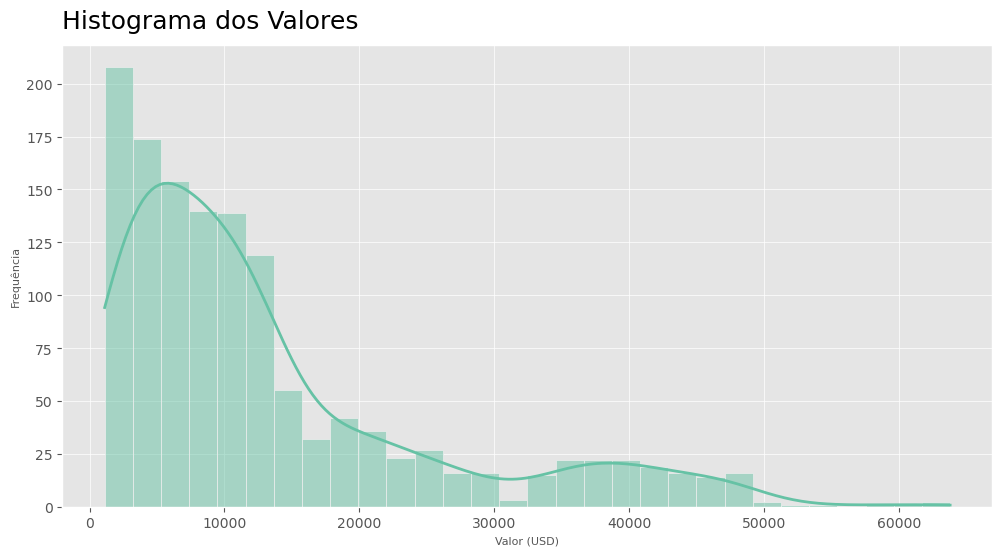

In [628]:
fig, ax = plt.subplots(figsize = (12, 6))

sns.histplot(df.charges, kde = True)
ax.set_title("Histograma dos Valores", loc = 'left', fontsize = 18, pad = 12)
ax.set_xlabel("Valor (USD)", fontsize = 8)
ax.set_ylabel("Frequência", fontsize = 8)
plt.show()

### Features x target

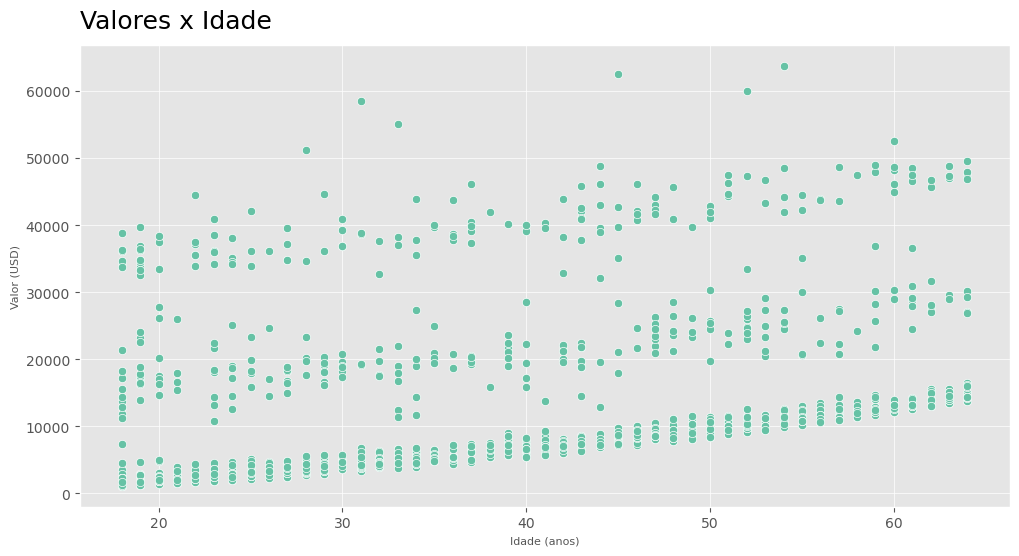

In [629]:
fig, ax = plt.subplots(figsize = (12, 6))

sns.scatterplot(x = df.age, y = df.charges)
ax.set_title("Valores x Idade", loc = 'left', fontsize = 18, pad = 12)
ax.set_xlabel("Idade (anos)", fontsize = 8)
ax.set_ylabel("Valor (USD)", fontsize = 8)
plt.show()

Existe uma correlação positiva entre a idade e os preços do seguro. O tabagismo também é um fator que pode pesar nos preços, vamos repetir o gráfico de dispersão mas agora destacando os fumantes.

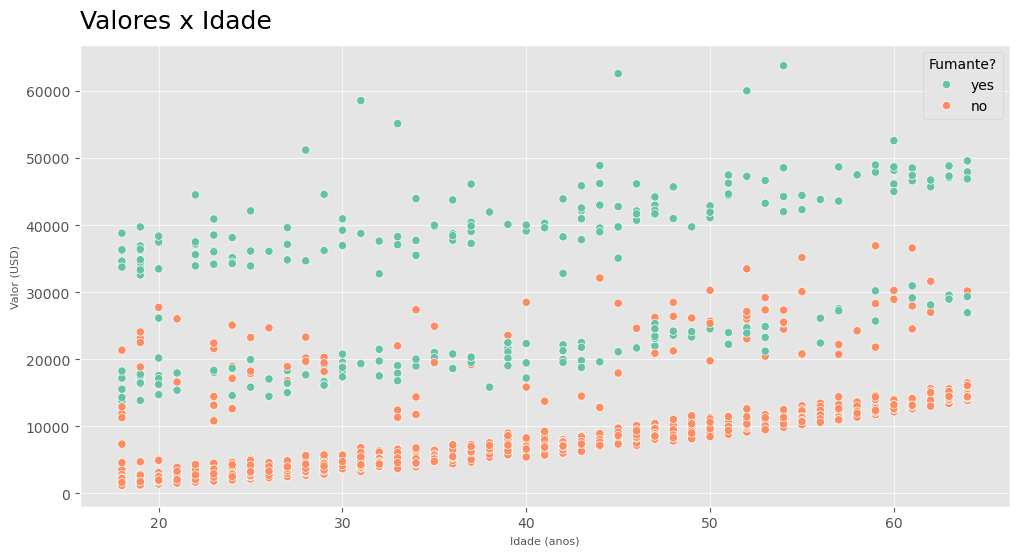

In [630]:
fig, ax = plt.subplots(figsize = (12, 6))

sns.scatterplot(x = df.age, y = df.charges, hue = df.smoker)
ax.set_title("Valores x Idade", loc = 'left', fontsize = 18, pad = 12)
ax.set_xlabel("Idade (anos)", fontsize = 8)
ax.set_ylabel("Valor (USD)", fontsize = 8)
plt.legend(title = 'Fumante?')
plt.show()

Os maiores valores de seguro são pagos por fumantes.

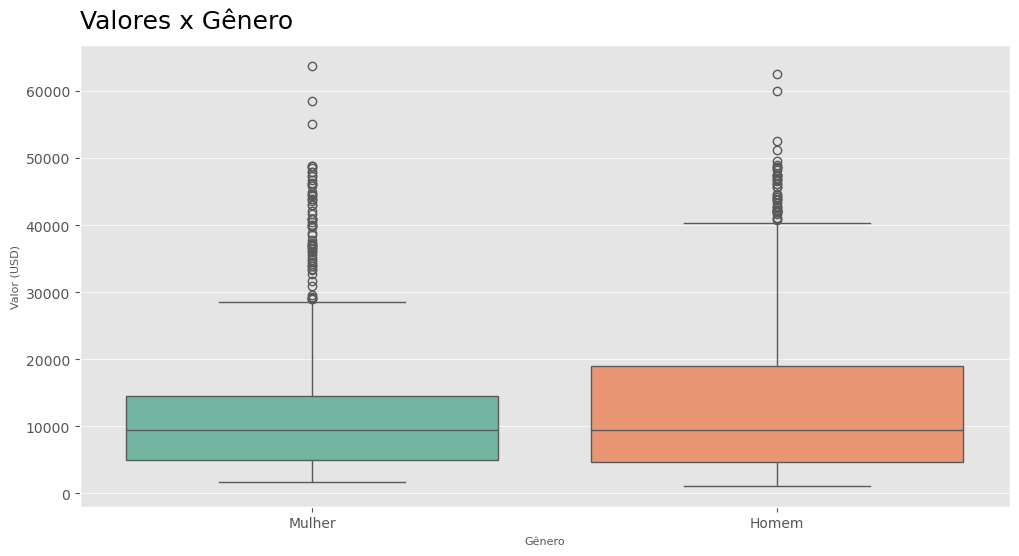

In [631]:
fig, ax = plt.subplots(figsize = (12, 6))

sns.boxplot(x = df.sex, y = df.charges, palette = 'Set2')
ax.set_title("Valores x Gênero", loc = 'left', fontsize = 18, pad = 12)
ax.set_xlabel("Gênero", fontsize = 8)
ax.set_ylabel("Valor (USD)", fontsize = 8)
ax.set_xticklabels({'Mulher': 'female', 'Homem': 'male'})
plt.show()

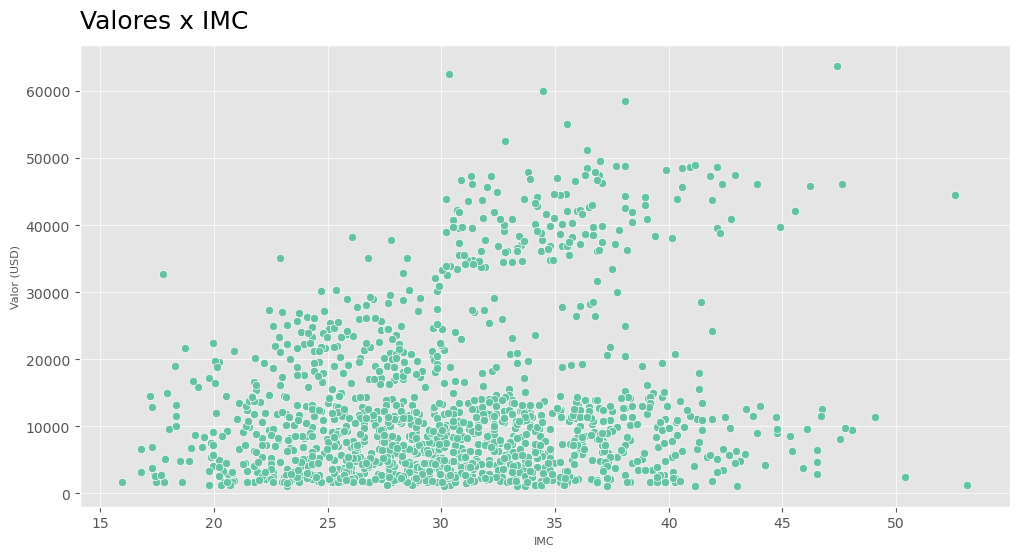

In [632]:
fig, ax = plt.subplots(figsize = (12, 6))

sns.scatterplot(x = df.bmi, y = df.charges)
ax.set_title("Valores x IMC", loc = 'left', fontsize = 18, pad = 12)
ax.set_xlabel("IMC", fontsize = 8)
ax.set_ylabel("Valor (USD)", fontsize = 8)
plt.show()

É possível observar alguns valores extremos, vamos checar se estes são fumantes. 

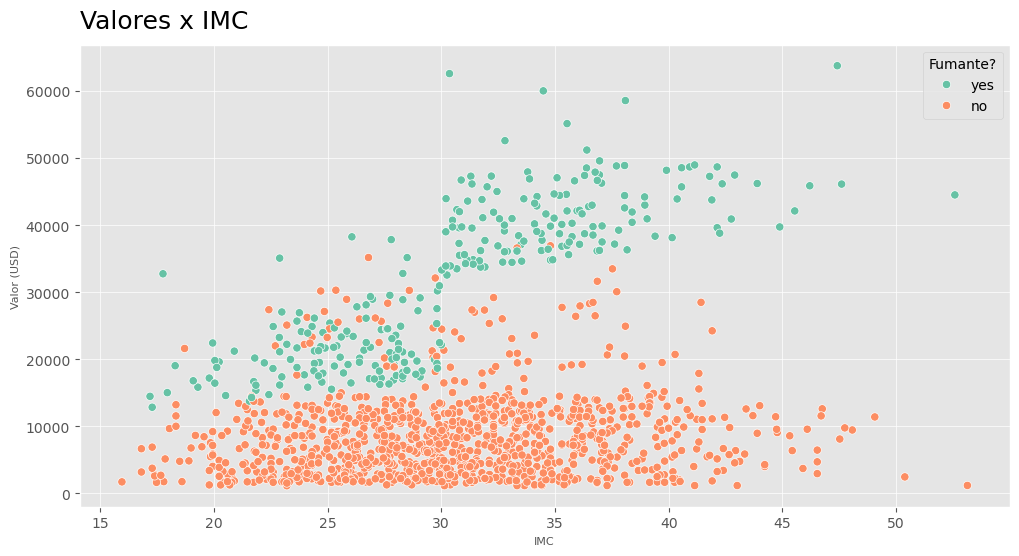

In [633]:
fig, ax = plt.subplots(figsize = (12, 6))

sns.scatterplot(x = df.bmi, y = df.charges, hue = df.smoker)
ax.set_title("Valores x IMC", loc = 'left', fontsize = 18, pad = 12)
ax.set_xlabel("IMC", fontsize = 8)
ax.set_ylabel("Valor (USD)", fontsize = 8)
plt.legend(title = 'Fumante?')
plt.show()

Novamente o tabismo se mostra um hábito que encarece o preço do seguro.

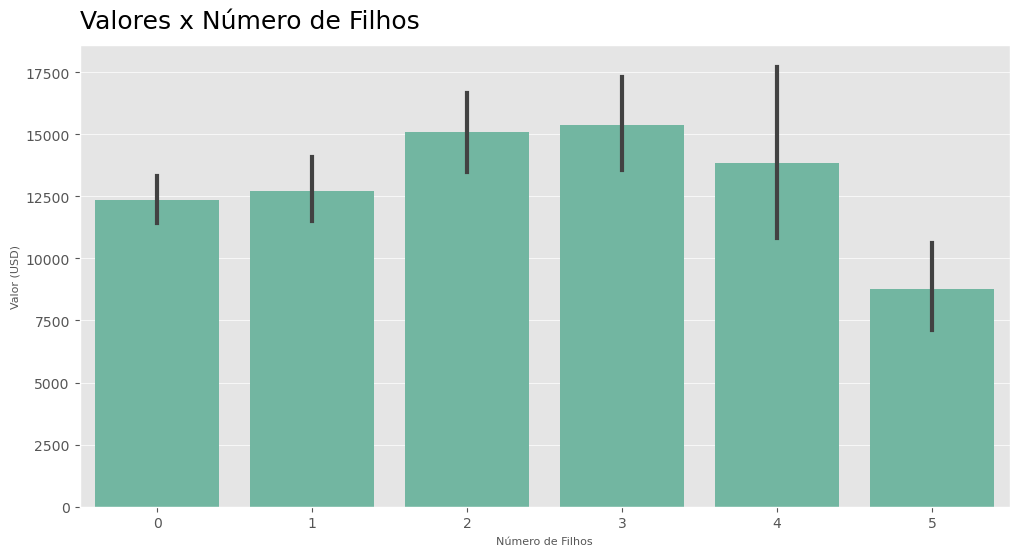

In [634]:
fig, ax = plt.subplots(figsize = (12, 6))

sns.barplot(x = df.children, y = df.charges)
ax.set_title("Valores x Número de Filhos", loc = 'left', fontsize = 18, pad = 12)
ax.set_xlabel("Número de Filhos", fontsize = 8)
ax.set_ylabel("Valor (USD)", fontsize = 8)
plt.show()

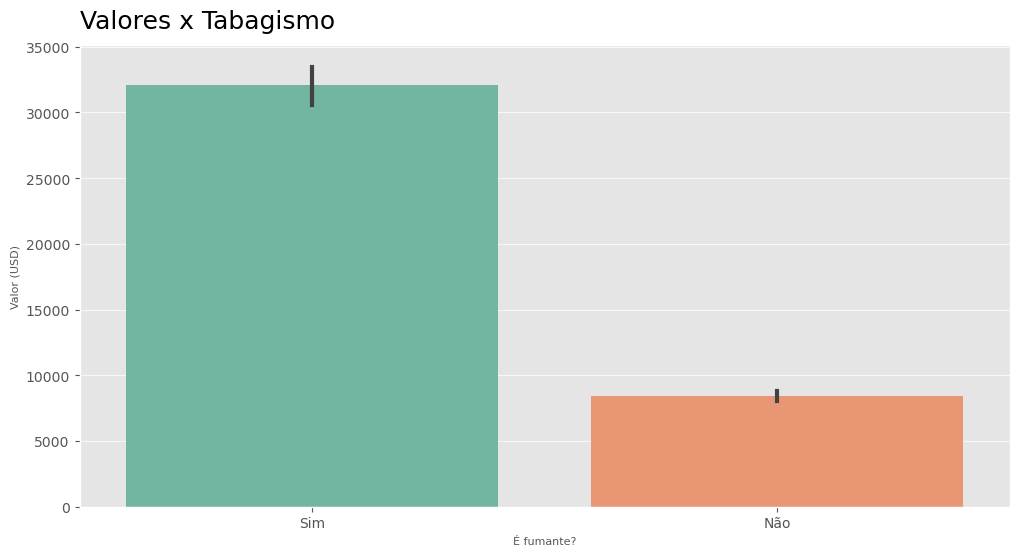

In [635]:
fig, ax = plt.subplots(figsize = (12, 6))

sns.barplot(x = df.smoker, y = df.charges, hue = df.smoker)
ax.set_title("Valores x Tabagismo", loc = 'left', fontsize = 18, pad = 12)
ax.set_xlabel("É fumante?", fontsize = 8)
ax.set_ylabel("Valor (USD)", fontsize = 8)
ax.set_xticklabels({'Sim': 'yes', 'Não': 'no'})
plt.show()

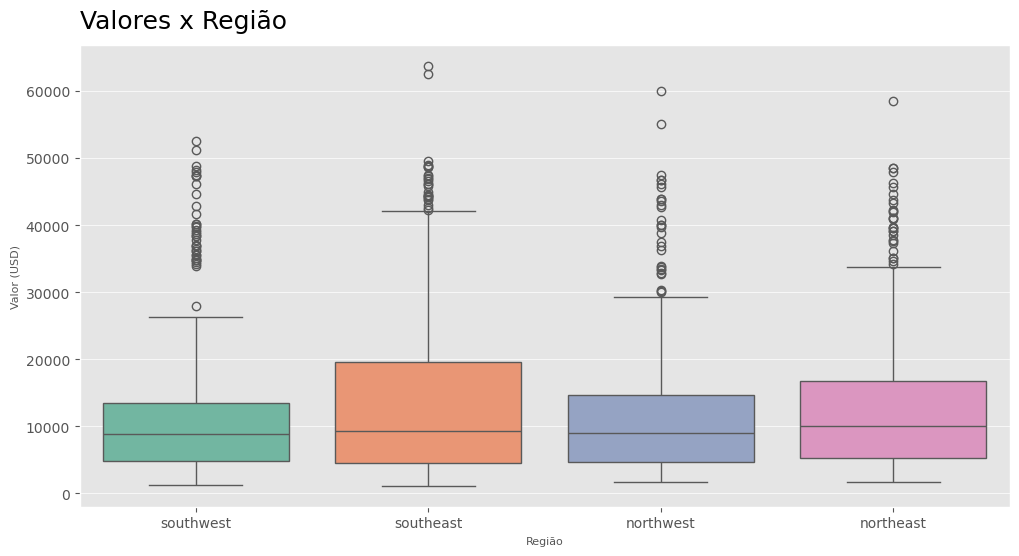

In [636]:
fig, ax = plt.subplots(figsize = (12, 6))

sns.boxplot(x = df.region, y = df.charges, hue = df.region)
ax.set_title("Valores x Região", loc = 'left', fontsize = 18, pad = 12)
ax.set_xlabel("Região", fontsize = 8)
ax.set_ylabel("Valor (USD)", fontsize = 8)
plt.show()

## 3.4. Correlação

Aqui farei a transformação das variáveis categóricas que podem ser consideradas booleanas (``sex`` e ``smoker``)

In [637]:
le = LabelEncoder()
corr_df = df.copy()
corr_df.sex = le.fit_transform(corr_df.sex)
corr_df.smoker = le.fit_transform(corr_df.smoker)
corr = corr_df.corr(numeric_only=True)

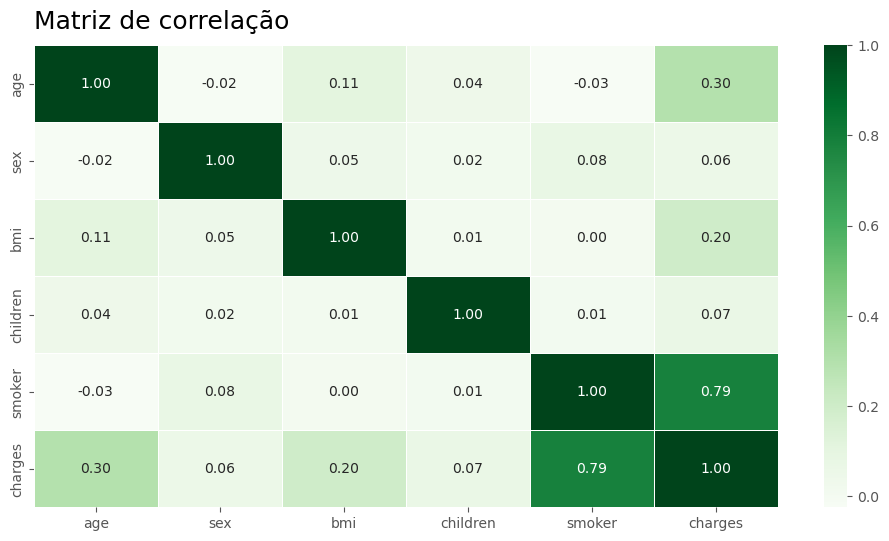

In [638]:
fig, ax = plt.subplots(figsize = (12, 6))

sns.heatmap(corr, annot = True, fmt = '.2f', cmap = 'Greens', linecolor='white', linewidths=0.5)
ax.set_title("Matriz de correlação", loc = 'left',fontsize = 18, pad = 12)
plt.show()

Idade, IMC e o Tabagismo são as principais variáveis relacionadas ao preço do seguro. 

# 4. Preparação dos dados

## 4.1. Seleção das features

In [639]:
features = df.drop(columns = 'charges').columns.to_list()
target = 'charges'

cat_features = df[features].select_dtypes(include = 'object').columns.to_list()
num_features = df[features].select_dtypes(include = 'number').columns.to_list()

Vou aplicar uma transformação logaritmica na variável dependente para buscar sua normalidade.

In [640]:
# Aplicando a transformação logarítmcia nos dados

df.charges = np.log(df.charges)

In [641]:
print(f"Assimétria: {df.charges.skew().round(4)}")
print(f"Curtose: {df.charges.kurt().round(4)}")

Assimétria: -0.0901
Curtose: -0.6367


Com uma assimétria próxima a zero, alcançamos uma melhora. 

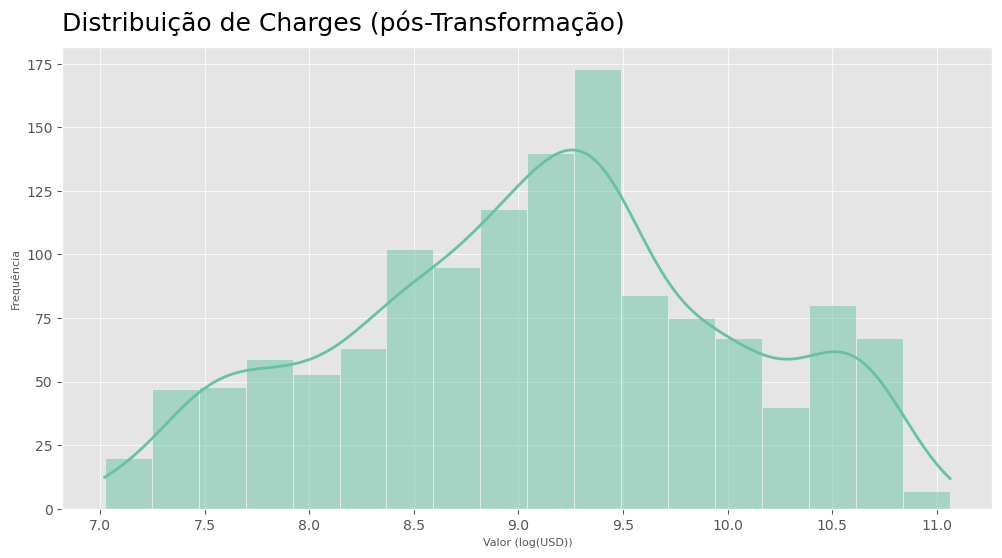

In [649]:
fig, ax = plt.subplots(figsize = (12, 6))

sns.histplot(df.charges, kde = True)
ax.set_title("Distribuição de Charges (pós-Transformação)", loc = 'left', fontsize = 18, pad = 12)
ax.set_xlabel("Valor (log(USD))", fontsize = 8)
ax.set_ylabel("Frequência", fontsize = 8)
plt.show()

## 4.2. Divisão em treino e teste

In [642]:
X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1070, 6) (268, 6) (1070,) (268,)


## 4.3. Definindo o pré-processamento

In [643]:

cat_transformer = Pipeline([
    ('ohe', OneHotEncoder())
])

num_transformer = Pipeline([
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', cat_transformer, cat_features),
        ('num', num_transformer, num_features)
    ]
)

# 5. Modelo de Regressão (XGBClassifier)

## 5.1. Instanciando o modelo

In [644]:
model = XGBRegressor()

xgb = Pipeline([
    ('preprocessor', preprocessor),
    ('model', model)
])

xgb.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder())]),
                                                  ['sex', 'smoker', 'region']),
                                                 ('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'bmi',
                                                   'children'])])),
                ('model',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=None, ...))])

## 5.2. Previsões e métricas

In [645]:
y_pred = xgb.predict(X_test)
print("Métricas do Modelo")
print("=" * 20)
print(f"R2 Score: {r2_score(y_test, y_pred).round(4)}\nMSE: {mean_squared_error(y_test, y_pred).round(4)}")

Métricas do Modelo
R2 Score: 0.815
MSE: 0.1664


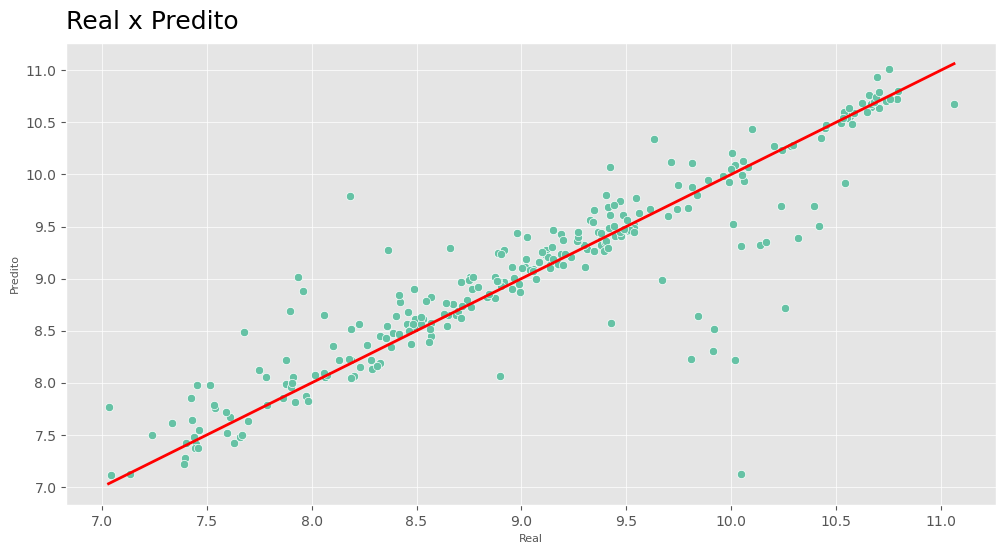

In [646]:
fig, ax = plt.subplots(figsize = (12, 6))

sns.scatterplot(x = y_test, y = y_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color = 'red')
ax.set_title("Real x Predito", loc = 'left', fontsize = 18, pad = 10)
ax.set_xlabel("Real", fontsize = 8)
ax.set_ylabel("Predito", fontsize = 8)
plt.show()

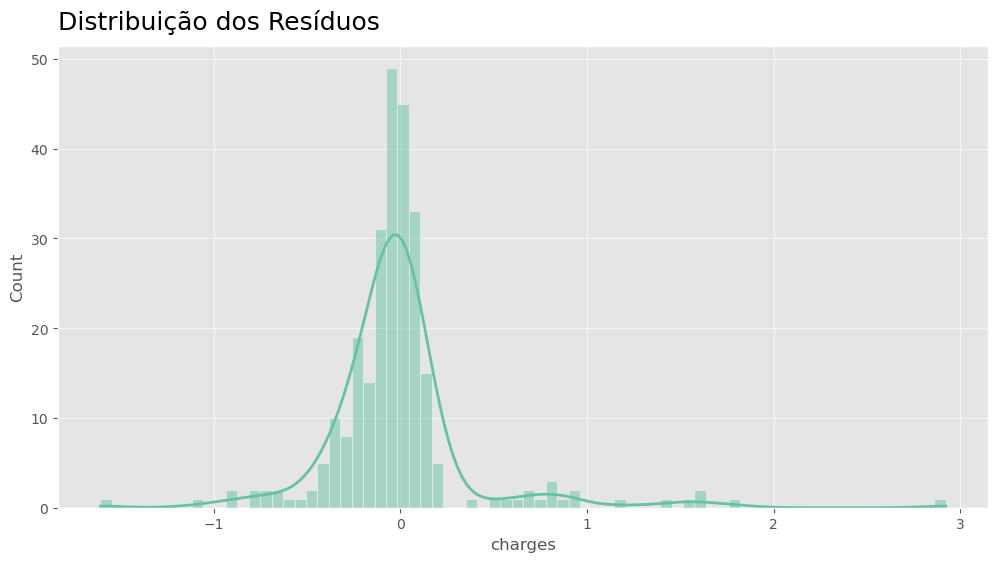

In [647]:
residual = y_test - y_pred

fig, ax = plt.subplots(figsize = (12, 6))
sns.histplot(residual, kde = True)
ax.set_title("Distribuição dos Resíduos", loc = 'left', fontsize = 18, pad = 12)

plt.show()

# 6. Conclusões

#### Insights da Análise Exploratória
- Tabagismo é o fator de maior peso no aumento do valor do seguro de saúde;
- Peso (IMC), e Idade são os outros fatores que tem maior efeito nos preços, hábitos saudáveis além de estender a vida também ajudam na saúde financeira; 

### Sobre o modelo 
Com o XGBRegressor alcançamos um modelo com as seguintes métricas:

|Métrica|Resultado
|---|---|
|R2 Score|0.815|
|Mean Squared Error|0.1664|